# This note book is to test whether we can use any prior to determine the causal direction for non linear additive noise models

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["LD_LIBRARY_PATH"]

'/vol/cuda/11.2.1-cudnn8.1.0.77/targets/x86_64-linux/lib:/vol/cuda/11.2.1-cudnn8.1.0.77/lib64:'

In [2]:
import sys
sys.path.append("/vol/bitbucket/ad6013/Research/gp-causal")
from models.PartObsBayesianGPLVM import PartObsBayesianGPLVM
import gpflow
import tensorflow as tf
from gpflow.config import default_float
import tensorflow_probability as tfp
from data.get_data import get_synthetic_dataset
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

tf.random.set_seed(0)
np.random.seed(0)

In [3]:
cause, effect, weight = get_synthetic_dataset(100, 100, "add_a", "normal")

In [4]:
from gpflow.base import Parameter
from gpflow.utilities import positive
from sklearn.preprocessing import StandardScaler
from models.BayesGPLVM import BayesianGPLVM


correct = 0
for idx in range(len(cause)):
    print(idx)
    x, y = cause[idx], effect[idx]

    x = StandardScaler().fit_transform(x).astype(np.float64)
    y = StandardScaler().fit_transform(y).astype(np.float64) 


    # # Conditional for cause
    # # Define kernel
    # sq_exp = gpflow.kernels.SquaredExponential(lengthscales=[0.01])
    # sq_exp.variance.assign(1)
    # linear_kernel = gpflow.kernels.Linear(variance=1)
    # kernel = gpflow.kernels.Sum([sq_exp, linear_kernel])
    # # Initialise approx posteroir and prior
    # X_mean_init = 0.1 * tf.cast(y, default_float())
    # X_var_init = tf.cast(
    #     np.random.uniform(0, 0.1, (y.shape[0], 1)), default_float()
    # )
    # x_prior_var = tf.ones((y.shape[0], 1), dtype=default_float())
    # inducing_variable = gpflow.inducing_variables.InducingPoints(
    #     np.random.randn(500, 1),
    # )

    # # Define marginal model
    # marginal_model = BayesianGPLVM(
    #     data=x,
    #     kernel=kernel,
    #     X_data_mean=X_mean_init,
    #     X_data_var=X_var_init,
    #     X_prior_var=x_prior_var,
    #     jitter=1e-4,
    #     inducing_variable=inducing_variable
    # )
    # marginal_model.likelihood.variance = Parameter(
    #     0.1, transform=positive(1e-6)
    # )
    # # Train everything
    # tf.print("Training everything")
    # gpflow.utilities.set_trainable(marginal_model.kernel, True)
    # gpflow.utilities.set_trainable(marginal_model.likelihood, True)
    # gpflow.utilities.set_trainable(marginal_model.X_data_mean , True)
    # gpflow.utilities.set_trainable(marginal_model.X_data_var, True)
    # gpflow.utilities.set_trainable(marginal_model.inducing_variable, True)
    # opt = gpflow.optimizers.Scipy()
    # opt_logs = opt.minimize(
    #     marginal_model.training_loss,
    #     marginal_model.trainable_variables,
    #     options=dict(maxiter=10000),
    # )
    # causal_marg_loss = marginal_model.elbo()

    # Define the prior
    sq_exp = gpflow.kernels.Matern52(
        lengthscales=[0.01]
    )
    linear_kernel = gpflow.kernels.Linear(variance=1)
    sq_exp.variance.assign(1)
    kernel = gpflow.kernels.Sum([sq_exp, linear_kernel])
    # Define moedl
    reg_gp_model = gpflow.models.GPR(data=(x, y), kernel=kernel, mean_function=None)
    reg_gp_model.likelihood.variance = Parameter(
        0.1, transform=positive(lower=1e-6)
    )
    # Train everything
    tf.print("Training everything")
    gpflow.utilities.set_trainable(reg_gp_model.kernel, True)
    gpflow.utilities.set_trainable(reg_gp_model.likelihood, True)
    opt = gpflow.optimizers.Scipy()
    opt_logs = opt.minimize(
        reg_gp_model.training_loss,
        reg_gp_model.trainable_variables,
        options=dict(maxiter=10000),
    )
    causal_cond_loss = reg_gp_model.log_marginal_likelihood().numpy()

    full_causal = causal_cond_loss 




#   # Define kernel
#     sq_exp = gpflow.kernels.SquaredExponential(lengthscales=[0.01])
#     sq_exp.variance.assign(1)
#     linear_kernel = gpflow.kernels.Linear(variance=1)
#     kernel = gpflow.kernels.Sum([sq_exp, linear_kernel])
#     # Initialise approx posteroir and prior
#     X_mean_init = 0.1 * tf.cast(y, default_float())
#     X_var_init = tf.cast(
#         np.random.uniform(0, 0.1, (y.shape[0], 1)), default_float()
#     )
#     x_prior_var = tf.ones((y.shape[0], 1), dtype=default_float())
#     inducing_variable = gpflow.inducing_variables.InducingPoints(
#         np.random.randn(500, 1),
#     )

#     # Define marginal model
#     marginal_model = BayesianGPLVM(
#         data=y,
#         kernel=kernel,
#         X_data_mean=X_mean_init,
#         X_data_var=X_var_init,
#         X_prior_var=x_prior_var,
#         jitter=1e-4,
#         inducing_variable=inducing_variable
#     )
#     marginal_model.likelihood.variance = Parameter(
#         0.1, transform=positive(1e-6)
#     )
#     # Train everything
#     tf.print("Training everything")
#     gpflow.utilities.set_trainable(marginal_model.kernel, True)
#     gpflow.utilities.set_trainable(marginal_model.likelihood, True)
#     gpflow.utilities.set_trainable(marginal_model.X_data_mean , True)
#     gpflow.utilities.set_trainable(marginal_model.X_data_var, True)
#     gpflow.utilities.set_trainable(marginal_model.inducing_variable, True)
#     opt = gpflow.optimizers.Scipy()
#     opt_logs = opt.minimize(
#         marginal_model.training_loss,
#         marginal_model.trainable_variables,
#         options=dict(maxiter=10000),
#     )
#     anti_causal_marg_loss = marginal_model.elbo()

    sq_exp = gpflow.kernels.Matern52(
        lengthscales=[0.01]
    )
    linear_kernel = gpflow.kernels.Linear(variance=1)
    sq_exp.variance.assign(1)
    kernel = gpflow.kernels.Sum([sq_exp, linear_kernel])
    # Define moedl
    reg_gp_model = gpflow.models.GPR(data=(y, x), kernel=kernel, mean_function=None)
    reg_gp_model.likelihood.variance = Parameter(
        0.1, transform=positive(lower=1e-6)
    )
    tf.print("Training everything")
    gpflow.utilities.set_trainable(reg_gp_model.kernel, True)
    gpflow.utilities.set_trainable(reg_gp_model.likelihood, True)
    opt = gpflow.optimizers.Scipy()
    opt_logs = opt.minimize(
        reg_gp_model.training_loss,
        reg_gp_model.trainable_variables,
        options=dict(maxiter=10000),
    )
    anti_causal_cond_loss = reg_gp_model.log_marginal_likelihood().numpy() 

    full_anti_causal = anti_causal_cond_loss 



    print(f"Run: {idx}, {full_causal}, {full_anti_causal}")
    # print(causal_marg_loss.numpy(), causal_cond_loss, anti_causal_marg_loss.numpy(), anti_causal_cond_loss )

    if full_causal > full_anti_causal:
        correct += 1

print(correct / len(cause))



0


2022-08-05 18:55:17.529470: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Training everything


2022-08-05 18:55:17.540534: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 18:55:17.540667: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 18:55:17.541284: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-05 18:55:17.542346: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Training everything
Run: 0, -13.86380291864802, -59.73796523415062
1
Training everything
Training everything
Run: 1, -23.554811436005465, -56.15076104416811
2
Training everything
Training everything
Run: 2, -8.412081490910424, -78.28121443799773
3
Training everything
Training everything
Run: 3, -26.01546654309992, -84.8068396447151
4
Training everything
Training everything
Run: 4, 14.22998986470796, -51.49220681625175
5
Training everything
Training everything
Run: 5, 4.434526297139314, -57.450954319992576
6
Training everything
Training everything
Run: 6, -10.82223446313381, -78.10963352426904
7
Training everything
Training everything
Run: 7, -31.687348019403444, -67.10627741256715
8
Training everything
Training everything
Run: 8, -12.505043590722323, -80.64108623445605
9
Training everything
Training everything
Run: 9, -25.85005157937678, -68.48607322711239
10
Training everything
Training everything
Run: 10, -10.391727664322275, -65.57846727811629
11
Training everything
Training everyth

In [1]:
import tensorflow as tf
import numpy as np
import gpflow

In [83]:
def generate_anm_data(sample_size):
    """
    Data generated from an ANM dataset.
    """
    # Sample the cause
    cause = np.random.normal(loc=0.0, scale=2.5, size=(sample_size, 1))
    # Sample the effect
    kernel = gpflow.kernels.RBF(
        variance=1,
        lengthscales=2.5
    ).K(cause, cause)
    noise = np.random.normal(loc=0, scale=0.5, size=sample_size)
    effect = np.random.multivariate_normal(
        mean=np.zeros(sample_size),
        cov=kernel
    ) + noise
    return (cause, effect)

In [84]:
cause, effect = generate_anm_data(1000)

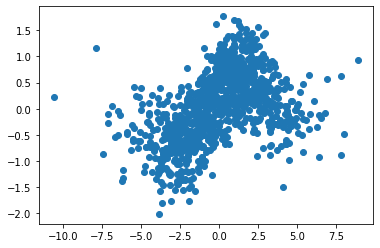

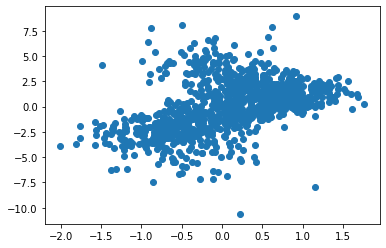

In [85]:
import matplotlib.pyplot as plt

plt.scatter(cause, effect)
plt.show()
plt.scatter(effect, cause)
plt.show()